In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import contract_18_decimals_to_float

# Making functions out of all required transformations and extractions

All of the work performed until this moment led to the aspect of automatization of the extractions, transformations and visualizations to be able to analyze each trader via performing some simple calls to the functions.

In [71]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def get_impermanent_loss(trading_df: pd.DataFrame, liquidity_df: pd.DataFrame, maker: str) -> pd.DataFrame:
    """get table of impermanent losses for trader at specific pool with respective data. Loss detection
    is considered via suggestion of a trader to play with a long position

    Args:
        trading_df (pd.DataFrame): trading dataframe with progress of price
        liquidity_df (pd.DataFrame): liquidity changes dataframe with updates of liquidity provisions
        maker (str): address of reviewed maker

    Returns:
        pd.DataFrame: impermanent and respective data dataframe
    """
    #   extract the required data out of the trading and liquidity dataframes
    maker_df = liquidity_df[liquidity_df["maker"] == maker][
        ["maker",  "pool_name", "time", "base", "quote", "quote_fee", "lower_bound", "upper_bound"]]
    
    maker_tokens_dataframes = []
    for token in maker_df["pool_name"].unique():
        maker_pool_df = maker_df[maker_df["pool_name"] == token]
        token_price_df = trading_df[trading_df["pool_name"] == token][["time", "swapped_price"]].dropna()
        
        #   form a token price dataframe
        token_price_df = token_price_df.set_index("time")
        token_price_df = token_price_df.resample("1T").mean()
        token_price_df.loc[(token_price_df["swapped_price"] <= (token_price_df["swapped_price"].median() / 100)), 
                        "swapped_price"] = np.NaN
        token_price_df = token_price_df.fillna(method='ffill')
        maker_pool_df["time"] = [datetime(time.year, time.month, time.day, time.hour, time.minute) 
                                for time in maker_pool_df["time"]]

        #   form a impermanent loss dataframe
        maker_pool_df = maker_pool_df.merge(token_price_df, on="time", how='inner')
        maker_pool_df["base_balance"] = maker_pool_df["base"].cumsum()
        maker_pool_df["prev_base_balance"] = maker_pool_df["base_balance"].shift(1)
        maker_pool_df["prev_swapped_price"] = maker_pool_df["swapped_price"].shift(1)
        
        #   calculate impermanent loss per change, cumulative one, absolute cumulative one
        maker_pool_df["swapped_impermanent_loss"] = ((maker_pool_df["prev_swapped_price"] - maker_pool_df["swapped_price"]) *
                                                maker_pool_df["prev_base_balance"])
        maker_pool_df["cumulative_swapped_impermanent_loss"] = maker_pool_df["swapped_impermanent_loss"].cumsum()
        maker_pool_df["absolute_cumulative_swapped_impermanent_loss"] = abs(maker_pool_df["swapped_impermanent_loss"]).cumsum()
        maker_pool_df["quote_balance"] = maker_pool_df["quote"].cumsum()
        
        maker_tokens_dataframes.append(maker_pool_df)
        
    return pd.concat(maker_tokens_dataframes)    


def show_cumulative_impermanent_loss(impermanent_loss_df: pd.DataFrame, abs_mode: bool=False,
                          xsize: int=14, ysize: int=7):
    """demonstrate cumulative impermanent loss progression through time

    Args:
        impermanent_loss_df (pd.DataFrame): dataframe of the impermanent loss
        abs_mode (bool): is it required to display absolute cumulative sum
                        or just a simple cumulative sum
        xsize (int, optional): horizontal size of chart. Defaults to 14.
        ysize (int, optional): vertical size of chart. Defaults to 7.
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    color_map = get_cmap(len(impermanent_loss_df["pool_name"].unique()))
    index = 0
    
    requested_column = "absolute_cumulative_swapped_impermanent_loss" if abs_mode else "cumulative_swapped_impermanent_loss"
    
    maker = impermanent_loss_df["maker"].unique()[0]
    
    for token in impermanent_loss_df["pool_name"].unique():
        token_impermanent_loss = impermanent_loss_df[impermanent_loss_df["pool_name"] == token]
        ax.plot(token_impermanent_loss["time"], token_impermanent_loss[requested_column], 
                color=color_map(index), marker='x', label=token + ' impermanent loss')
        ax.set_xlabel("time")
        ax.set_ylabel("USD")
        ax.set_title("Cumulative impermanent loss based on swap price by " + maker)
        index += 1
        
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.show()
    
    
def show_impermanent_loss(impermanent_loss_df: pd.DataFrame, xsize: int=14, ysize: int=7):
    """demonstrate pure impermanent loss distribution per each pool for trader

    Args:
        impermanent_loss_df (pd.DataFrame): impermanent loss table for trader
        xsize (int, optional): horizontal size. Defaults to 14.
        ysize (int, optional): vertical size. Defaults to 7.
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    color_map = get_cmap(len(impermanent_loss_df["pool_name"].unique()))
    index = 0
    
    maker = impermanent_loss_df["maker"].unique()[0]
    
    for token in impermanent_loss_df["pool_name"].unique():
        token_impermanent_loss = impermanent_loss_df[impermanent_loss_df["pool_name"] == token]
        ax.plot(token_impermanent_loss["time"], token_impermanent_loss["swapped_impermanent_loss"], 
                color=color_map(index), marker='x', label=token + ' impermanent loss')
        ax.set_xlabel("time")
        ax.set_ylabel("USD")
        ax.set_title("Impermanent loss based on swap price by " + maker)
        index += 1
        
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.show()
    
    
def get_max_drawdown(trading_df: pd.DataFrame, token: str, resolution: str="hourly") -> pd.DataFrame:
    """get table of maximal drawdowns

    Args:
        trading_df (pd.DataFrame): trading dataframe
        token (str): token for which max drawdown is calculated
        resolution (str): resolution of max drawdown. Defaults to "hourly"

    Returns:
        pd.DataFrame: dataframe of max drawdowns with required data
    """
    trading_prices_df = trading_df[trading_df["pool_name"] == token][
        ["time", "swapped_price", "entry_price_after", "market_price_after"]].dropna()
    resample_res = None
    
    if resolution == "hourly":
        resample_res = 'H'
    elif resolution == "daily":
        resample_res = 'D'
    else:
        raise ValueError("Unknown resolution")
    
    max_res_prices = trading_prices_df.resample(resample_res, on="time").max()
    max_res_prices.drop(columns=["time"], inplace=True)
    max_res_prices.rename(columns={"swapped_price": "max_swap_price", 
                                    "entry_price_after": "max_entry_price", 
                                    "market_price_after": "max_market_price"}, 
                                        inplace=True)
    min_res_prices = trading_prices_df.resample(resample_res, on="time").min()
    min_res_prices.drop(columns=["time"], inplace=True)
    min_res_prices.rename(columns={"swapped_price": "min_swap_price", 
                                        "entry_price_after": "min_entry_price", 
                                        "market_price_after": "min_market_price"}, 
                                        inplace=True)
    res_prices = pd.concat([max_res_prices, min_res_prices], axis=1, join='inner')
    res_prices["swap_max_drawdown"] = ((res_prices["max_swap_price"] - res_prices["min_swap_price"]) / 
                                                res_prices["max_swap_price"] * 100)
    res_prices["entry_max_drawdown"] = ((res_prices["max_entry_price"] - res_prices["min_entry_price"]) / 
                                                res_prices["max_entry_price"] * 100)
    res_prices["market_max_drawdown"] = ((res_prices["max_market_price"] - res_prices["min_market_price"]) / 
                                                res_prices["max_market_price"] * 100)
    
    return res_prices


def show_max_drawdowns(drawdowns_df: pd.DataFrame, token: str, separate_plots: bool=False, 
                        threshold: int=99, xsize: int=14, ysize: int=7):
    """visualize all drawdowns

    Args:
        drawdowns_df (pd.DataFrame): dataframe of drawdowns
        token (str): token for which drawdowns were found
        separate_plots (bool, optional): is it required to separate plots. Defaults to False.
        threshold (int, optional): threshold for filtering values. Defaults to 99.
        xsize (int, optional): horizontal size of plot. Defaults to 14.
        ysize (int, optional): vertical size of plot. Defaults to 7.
    """
    if not separate_plots:
        fig, ax = plt.subplots(figsize=(xsize, ysize))

        ax.plot(drawdowns_df[drawdowns_df["swap_max_drawdown"] < threshold].index, 
                drawdowns_df[drawdowns_df["swap_max_drawdown"] < threshold]["swap_max_drawdown"], 
                color='r', label='swap_drawdown')
        ax.plot(drawdowns_df[drawdowns_df["entry_max_drawdown"] < threshold].index, 
                drawdowns_df[drawdowns_df["entry_max_drawdown"] < threshold]["entry_max_drawdown"], 
                color='g', label='entry_price_drawdown')
        ax.plot(drawdowns_df[drawdowns_df["market_max_drawdown"] < threshold].index, 
                drawdowns_df[drawdowns_df["market_max_drawdown"] < threshold]["market_max_drawdown"], 
                color='b', label='market_price_drawdown')
        ax.set_xlabel("time")
        ax.set_ylabel("%")
        ax.set_title("Max drawdowns for " + token)
        ax.grid(True, linestyle='--')
        ax.legend()
        plt.show()
        return
        
    else:
        fig = plt.figure(figsize=(xsize, ysize))
        
        ax = fig.add_subplot(1, 3, 1)
        filtered_drawdowns_df = drawdowns_df[drawdowns_df["swap_max_drawdown"] < threshold]
        ax.plot(filtered_drawdowns_df.index, filtered_drawdowns_df["swap_max_drawdown"], 
                color='r', label='swap_drawdown')
        ax.set_ylabel("%")
        ax.set_title("Max drawdowns for swap price of " + token)
        ax.grid(True, linestyle='--')
        
        ax = fig.add_subplot(1, 3, 2)
        filtered_drawdowns_df = drawdowns_df[drawdowns_df["entry_max_drawdown"] < threshold]
        ax.plot(filtered_drawdowns_df.index, filtered_drawdowns_df["entry_max_drawdown"], 
                color='g', label='entry_price_drawdown')
        ax.set_ylabel("%")
        ax.set_title("Max drawdowns for entry price of " + token)
        ax.grid(True, linestyle='--')
        
        ax = fig.add_subplot(1, 3, 3)
        filtered_drawdowns_df = drawdowns_df[drawdowns_df["market_max_drawdown"] < threshold]
        ax.plot(filtered_drawdowns_df.index, filtered_drawdowns_df["market_max_drawdown"], 
                color='b', label='market_price_drawdown')
        ax.set_ylabel("%")
        ax.set_title("Max drawdowns for market price of " + token)
        ax.grid(True, linestyle='--')

        fig.tight_layout()        
        plt.show()
        
        
def get_trader_money_balance(trading_df: pd.DataFrame, trader: str) -> pd.DataFrame:
    """get dataframe with money balance and info based on which it was found

    Args:
        trading_df (pd.DataFrame): overall trading dataframe
        trader (str): trader for which balance will be found

    Returns:
        pd.DataFrame: dataframe of money balance for specific trader
    """
    trader_df = trading_df[trading_df["trader"] == trader][["trader", "time", "pool_name", "open_notional", "deposit", 
                                                            "withdraw", "realized_pnl", "funding_payment"]]
    trader_df.fillna(0, inplace=True)
    trader_df["money_movement"] = (trader_df["deposit"] - trader_df["withdraw"] + 
                                   trader_df["realized_pnl"] + trader_df["funding_payment"])
    trader_df["money_balance"] = trader_df["money_movement"].cumsum()
    return trader_df


def show_trader_money_balance(trader_balance_df: pd.DataFrame,
                              xsize: int=14, ysize: int=7):
    """visualize money balance for specific trader

    Args:
        trader_balance_df (pd.DataFrame): money balance of the specific trader
        xsize (int, optional): horizontal size. Defaults to 14.
        ysize (int, optional): vertical size. Defaults to 7.
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    trader = trader_money_balance_df["trader"].unique()[0]
    
    ax.bar(trader_balance_df[trader_balance_df["money_movement"] >= 0]["time"], 
        trader_balance_df[trader_balance_df["money_movement"] >= 0]["money_movement"],
        color='g', label='positive money movement')
    ax.bar(trader_balance_df[trader_balance_df["money_movement"] < 0]["time"], 
        trader_balance_df[trader_balance_df["money_movement"] < 0]["money_movement"],
        color='r', label='negative money movement')
    ax.plot(trader_balance_df["time"], trader_balance_df["money_balance"],
        color='b', label='money balance')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.legend()
    ax.grid(True, linestyle='--')
    ax.set_title("Money flow for " + trader)
    plt.show()
        

def show_buying_power(trader_balance_df: pd.DataFrame,
                      xsize: int=14, ysize: int=7):
    """visualize buying power distribution for trader per pools where
    this address participated

    Args:
        trader_balance_df (pd.DataFrame): trader money balance dataframe
        xsize (int, optional): horizontal size. Defaults to 14.
        ysize (int, optional): vertical size. Defaults to 7.
    """
    trader_balance_df = trader_balance_df[trader_balance_df["open_notional"] != 0]
    trader_balance_df = trader_balance_df[trader_balance_df["pool_name"] != 0]
    trader_balance_df["position_to_balance_perc"] = (trader_balance_df["open_notional"] / 
                                                     trader_balance_df["money_balance"]) * 100
    
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    cmap = get_cmap(len(trader_balance_df["pool_name"].unique()))
    index = 0
    trader = trader_balance_df["trader"].unique()[0]
    for token in trader_balance_df["pool_name"].unique():
        token_trader_balance_df = trader_balance_df[trader_balance_df["pool_name"] == token]
        ax.plot(token_trader_balance_df["time"], token_trader_balance_df["position_to_balance_perc"], 
                color=cmap(index), label=token)
        ax.set_ylabel("%")
        index += 1 
    ax.grid(True, linestyle='--')
    ax.legend()
    ax.set_title("Distribution of applied buying power per pool for " + trader)
    plt.show()
    
    
def show_trader_overview(trading_df: pd.DataFrame, trader: str, xsize: int=14, ysize: int=7):
    """show trader overview considering profits, losses, funding payments, fee,
    liquidation fee

    Args:
        trading_df (pd.DataFrame): trading dataframe
        trader (str): address of the trader for which overview will be shown
        xsize (int, optional): horizontal size. Defaults to 14.
        ysize (int, optional): vertical size. Defaults to 7.
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    trader_trading_df = trading_df[trading_df["trader"] == trader]
    ax2 = ax.twinx()
    
    ax.bar(trader_trading_df[trader_trading_df["realized_pnl"] > 0]["time"], 
        trader_trading_df[trader_trading_df["realized_pnl"] > 0]["realized_pnl"], 
        color='g', label='profits')
    ax.bar(trader_trading_df[trader_trading_df["realized_pnl"] <= 0]["time"], 
        trader_trading_df[trader_trading_df["realized_pnl"] <= 0]["realized_pnl"], 
        color='r', label='losses')
    
    daily_trader_trading_df = trader_trading_df[["time", "funding_payment", "fee", "liquidation_fee"]
                                                ].resample('D', on="time").sum()
    ax2.plot(daily_trader_trading_df.index, daily_trader_trading_df["funding_payment"], 
            color='b', label='funding payment')
    ax2.plot(daily_trader_trading_df.index, daily_trader_trading_df["fee"], color='r', label='fee')
    ax2.plot(daily_trader_trading_df.index, daily_trader_trading_df["liquidation_fee"], 
            color='m', label='liquidation fee')
    ax.set_ylabel("USD")
    ax.set_title("trader overview for " + trader)
    ax.grid(True, linestyle='--')
    fig.legend()
    plt.show()


tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

# Making calls, demonstrating functions

In [3]:
master_trader_df = pd.read_csv("master_trader.csv")
master_trader_df.drop(columns=["Unnamed: 0", "tx_hash"], inplace=True)
master_trader_df["time"] = pd.to_datetime(master_trader_df["timestamp"], unit='s')
master_trader_df

,trader,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,...,mark_twap,index_twap,daily_funding_rate,deposit,withdraw,liquidator,liquidation_fee,position_size_abs,position_notional_abs,block_number
0,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,250000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54295.708000,55072.675000,-0.014108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4104.856899,4167.914502,-0.015129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54295.708000,55072.675000,-0.014108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7522802,0x66465ad392942e78f8147ae565a43f174071822b,-63.016538,1007.767544,1.007768,77543.167127,0.0,-4785.063498,15.992112,16.205254,15.968758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7522803,0x31789f360b9aab20837a35944904deb540533357,-5.821204,1250.535778,1.250536,28511.176773,0.0,-132.045808,214.824254,215.918833,214.596023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7522804,0xdab8a2e0b213ec8447d4f7cdb783d53ed3428b7a,-3419.000000,806.897384,0.806897,806.090487,0.0,-3419.000000,0.236004,0.235768,0.235708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7522805,0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca,-1220.524515,750.778051,0.750778,74113.308142,0.0,-122785.420591,0.615127,0.603600,0.614201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
liquidity_changes_df = pd.read_csv("liquidity_changes.csv")
liquidity_changes_df["time"] = pd.to_datetime(liquidity_changes_df["timestamp"], unit='s')
liquidity_changes_df["day_of_year"] = liquidity_changes_df["time"].dt.dayofyear
liquidity_changes_df["pool_name"] = liquidity_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
liquidity_changes_df.drop(columns=["base_token", "tx_hash", "from_function_signature"], inplace=True)
liquidity_changes_df["lower_bound"] = pow(1.0001, liquidity_changes_df["lower_tick"])
liquidity_changes_df["upper_bound"] = pow(1.0001, liquidity_changes_df["upper_tick"])
liquidity_changes_df["fixed_liquidity"] = [contract_18_decimals_to_float(liquidity_record) for 
                                           liquidity_record in liquidity_changes_df["liquidity"]]
liquidity_changes_df.drop(columns=["Unnamed: 0", "quote_token", "lower_tick", "upper_tick", "liquidity"], 
                          inplace=True)
liquidity_changes_df["central_bound"] = (liquidity_changes_df["upper_bound"] + liquidity_changes_df["lower_bound"]) / 2
liquidity_changes_df.sort_values("block_number_log_index", inplace=True)
liquidity_changes_df = liquidity_changes_df.reset_index()
liquidity_changes_df.drop(columns=["index"], inplace=True)

liquidity_changes_df

,id,maker,base,quote,quote_fee,block_number_log_index,block_number,timestamp,time,day_of_year,pool_name,lower_bound,upper_bound,fixed_liquidity,central_bound
0,0xec1e410b931f920c4aa3ae105e63463142b310fbe959...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.000921,50.000000,0.000000,515552004,515552,1638000985,2021-11-27 08:16:25,331,vBTC,2.954278e-39,3.384921e+38,0.214579,1.692461e+38
1,0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0.012181,50.000000,0.000000,515554004,515554,1638000985,2021-11-27 08:16:25,331,vETH,2.954278e-39,3.384921e+38,0.780407,1.692461e+38
2,0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,3.572179,200000.000000,0.000000,515555003,515555,1638000985,2021-11-27 08:16:25,331,vBTC,5.171263e+04,5.692287e+04,35648.835497,5.431775e+04
3,0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,46.254982,200000.000000,0.000000,515557003,515557,1638000985,2021-11-27 08:16:25,331,vETH,3.895536e+03,4.313830e+03,120851.329740,4.104683e+03
4,0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...,0x35952141922ee99a04e016c967c3f0ad589ea958,0.100000,472.798469,0.000000,516478004,516478,1638003992,2021-11-27 09:06:32,331,vETH,3.990155e+03,4.288026e+03,386.315245,4.139091e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130054,0xf3155f56c66c05c95611e7947304853aab760c5ff395...,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,-1683.962836,0.000000,144.993911,11554393008,11554393,1655117811,2022-06-13 10:56:51,164,vAAVE,5.948926e+01,7.164952e+01,-146260.729784,6.556939e+01
130055,0xc8c4310f0bb74d949669849479190ba4b1eebee33f58...,0x377e6326a8e2ce4a856d31605ca33505ad2b57b1,1435.815543,4999.462445,0.000000,11554604003,11554604,1655117891,2022-06-13 10:58:11,164,vAPE,3.478628e-01,3.487682e+01,3917.139686,1.761234e+01
130056,0x8e7f48783a1d80dc4a058e7595f89d5d485d9d054f27...,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,1708.506923,0.000000,0.000000,11554671003,11554671,1655117952,2022-06-13 10:59:12,164,vAAVE,5.877969e+01,7.037143e+01,152196.723027,6.457556e+01
130057,0xb7473ff85536e28acf2175d68acbbf68351a02dd7a7a...,0x377e6326a8e2ce4a856d31605ca33505ad2b57b1,-331.643015,-4978.735548,2.235039,11555163007,11555163,1655118198,2022-06-13 11:03:18,164,vAVAX,1.512826e+00,1.516763e+02,-1878.686957,7.659458e+01


Functions that can be called:

1. Get and show impermanent loss;
2. Get and show max drawdown (there are two versions - hourly and daily basis);
3. Get and show money balance;
4. Show buying power.

In [30]:
impermanent_loss_df = get_impermanent_loss(master_trader_df, liquidity_changes_df, 
                                            "0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420")
impermanent_loss_df

,maker,pool_name,time,base,quote,quote_fee,lower_bound,upper_bound,swapped_price,base_balance,prev_base_balance,prev_swapped_price,swapped_impermanent_loss,cumulative_swapped_impermanent_loss,absolute_cumulative_swapped_impermanent_loss,quote_balance
0,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vFTM,2022-05-23 08:57:00,20271.162016,0.0,0.000000,0.495611,0.693515,0.492677,2.027116e+04,NaN,NaN,NaN,NaN,NaN,0.0
1,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vFTM,2022-05-24 02:02:00,22529.391240,0.0,0.000000,0.444876,0.532609,0.443105,4.280055e+04,20271.162016,0.492677,1004.878831,1004.878831,1004.878831,0.0
2,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vFTM,2022-05-24 02:11:00,-20271.162016,0.0,31.587871,0.495611,0.693515,0.333394,2.252939e+04,42800.553256,0.443105,4695.690272,5700.569103,5700.569103,0.0
3,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vFTM,2022-05-24 03:00:00,21000.809014,5500.0,0.000000,0.399335,0.539038,0.445196,4.353020e+04,22529.391240,0.333394,-2518.815154,3181.753949,8219.384257,5500.0
4,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vFTM,2022-05-24 06:11:00,-22529.391240,0.0,10.351005,0.444876,0.532609,0.442763,2.100081e+04,43530.200254,0.445196,105.912507,3287.666456,8325.296764,5500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vPERP,2022-06-10 11:08:00,-47939.336237,0.0,24.821088,1.049168,1.256071,1.037774,0.000000e+00,47939.336237,1.042491,226.118163,3723.795038,3723.795038,0.0
8,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vPERP,2022-06-10 20:25:00,61990.356198,0.0,0.000000,0.970447,1.161826,0.966509,6.199036e+04,0.000000,1.037774,0.000000,3723.795038,3723.795038,0.0
9,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vPERP,2022-06-10 22:36:00,-61990.356198,0.0,0.000000,0.970447,1.161826,0.964848,0.000000e+00,61990.356198,0.966509,102.931853,3826.726891,3826.726891,0.0
0,0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420,vETH,2022-06-13 01:23:00,146.333894,0.0,0.000000,1371.470532,1641.933557,1364.103613,1.463339e+02,NaN,NaN,NaN,NaN,NaN,0.0


# Demonstration of the impermanent loss with different approaches

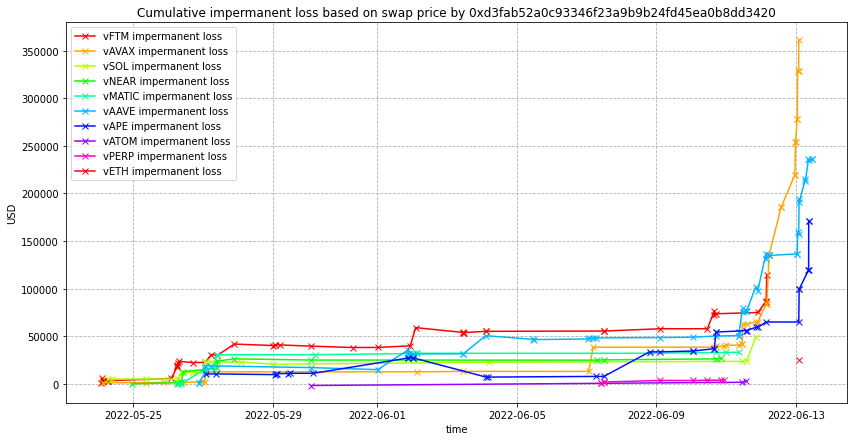

In [31]:
show_cumulative_impermanent_loss(impermanent_loss_df, abs_mode=False)

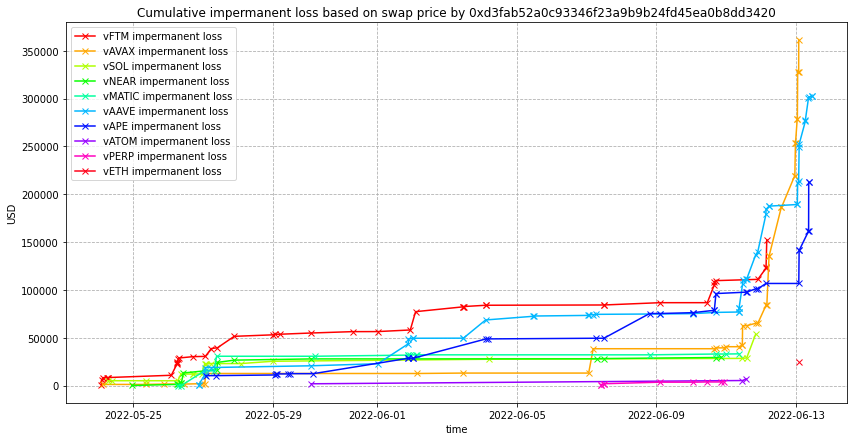

In [32]:
show_cumulative_impermanent_loss(impermanent_loss_df, abs_mode=True)

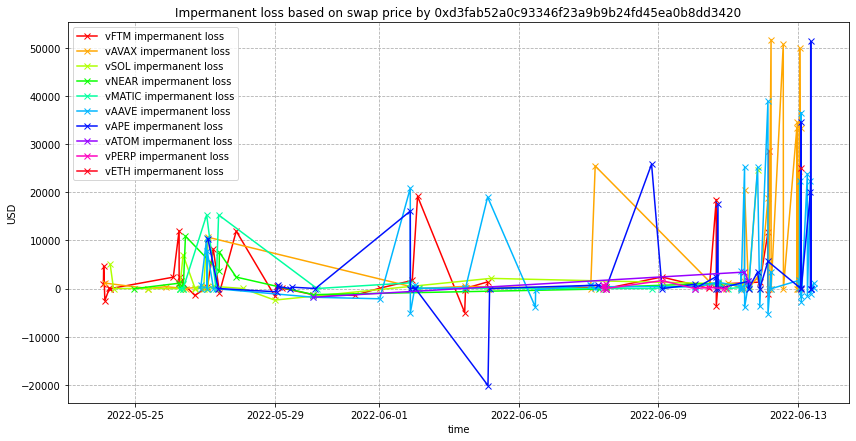

In [24]:
show_impermanent_loss(impermanent_loss_df)

Current implementation of the impermanent loss is based around concept that there could be performed sell of obtained token. To understand how it works we suppose that this maker was able to make a trading position and perform Perpetual trading. We suppose that trader makes a long position by purchasing the respective token and how much profit this maker would be able to make with such amount of tokens traded. Impermanent loss is calculated conform the formula per each liquidity update:

*impermanent loss = balance before current update * (previous update token price - current update token price)*

Positive value will cover case, when trader could have lost his money in case of performing a long position trading (but could get a profit out of the short position), while negative value will cover case of possible profit that could have been extracted out of the performing long position trading. Considering that there are options for trader to adapt to the market changes there are several approaches for finding (or demonstrating) the impermanent loss:

1. Simple one, suggests long position with rules mentioned above and is closer to the concept of "just holding" the tokens;
2. Cumulative one, suggesting that trader makes and long position and how losses would progress through time;
3. Advanced cumulative one with absolute cumulative sum of losses suggesting that there is an advanced trader that will be able to play on market changes via both long and short positions and what could be the profits

# Demonstration of the max drawdowns

Max drawdowns are found for token and demonstrate how strong are the deviations of the token price and therefore how risky it is to invest into the presented token. Considering that there are 3 plots visualized there are two options of how to do it:

1. Demonstrate all those plots in one chart;
2. Demonstrate those plots is different subcharts.

Below there are shown 4 tokens.

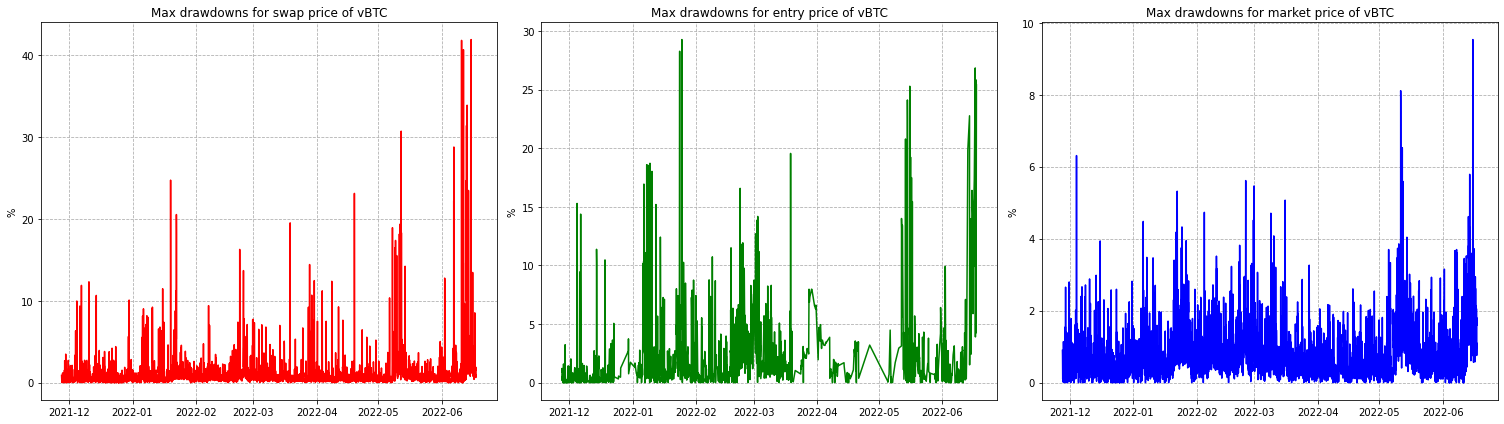

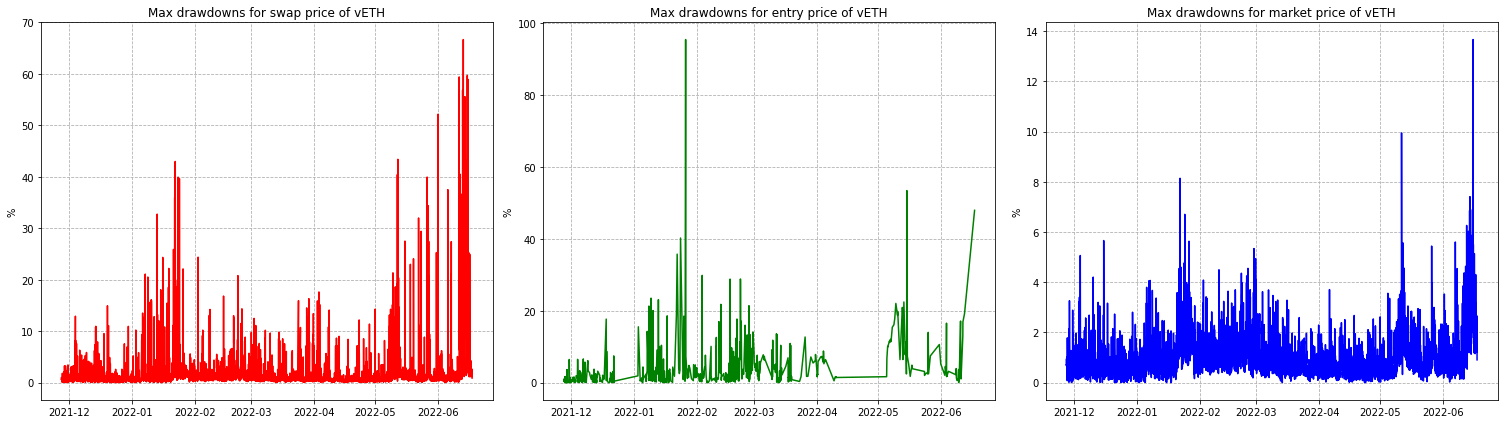

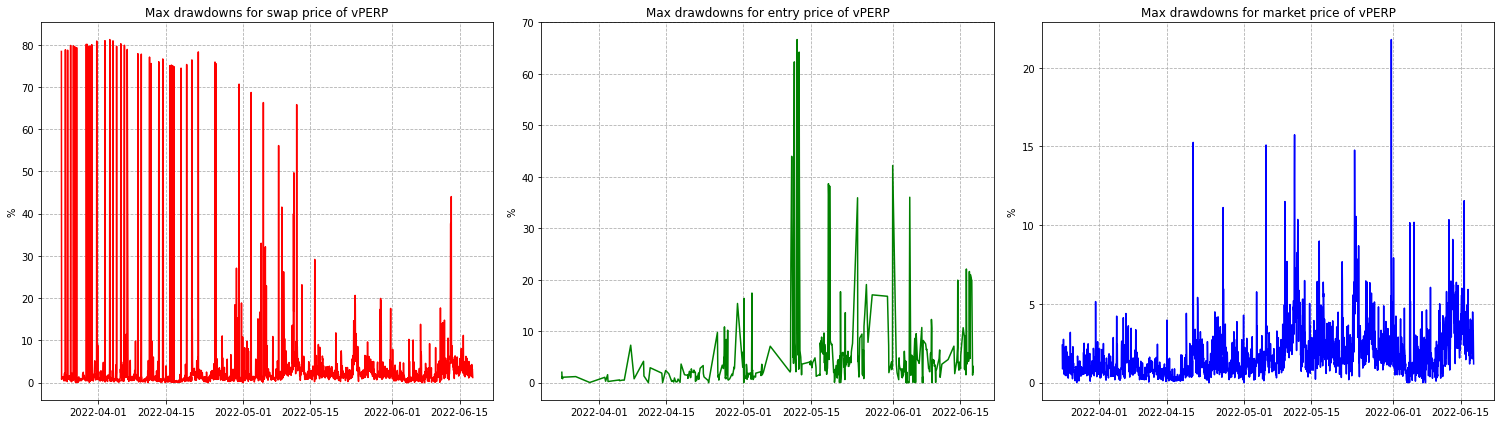

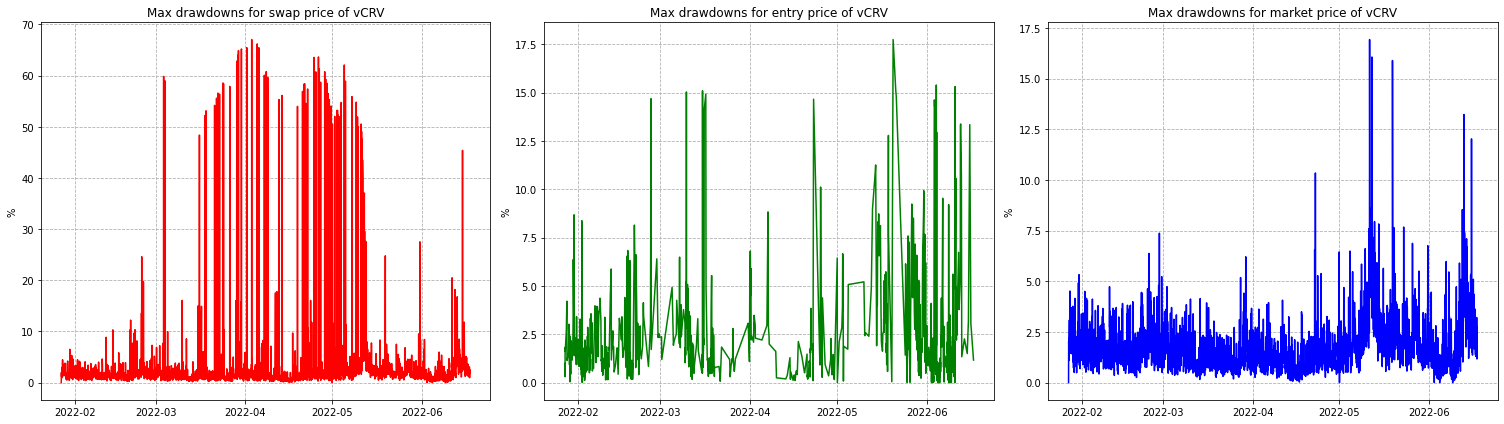

In [41]:
for token in ["vBTC", "vETH", "vPERP", "vCRV"]:
    max_drawdowns_df = get_max_drawdown(master_trader_df, token)
    show_max_drawdowns(max_drawdowns_df, token, separate_plots=True, xsize=21, ysize=6)

Conform the presented charts can be seen how unstable are the token prices and therefore investments are extremely risky. Efficient approach for those tokens will be in non-ending track of the token price or to make a bot that will track the price and check if there is a need to apply a change or to liquidate the position.

# Demonstration of the trading overview

The main chart for the trader analysis is the money balance one where can be seen money movement and the money balance. Money movement demonstrates all incomes and outcomes of the money, but the balance demostrates progression of the money movement on the platform for the specific trader.

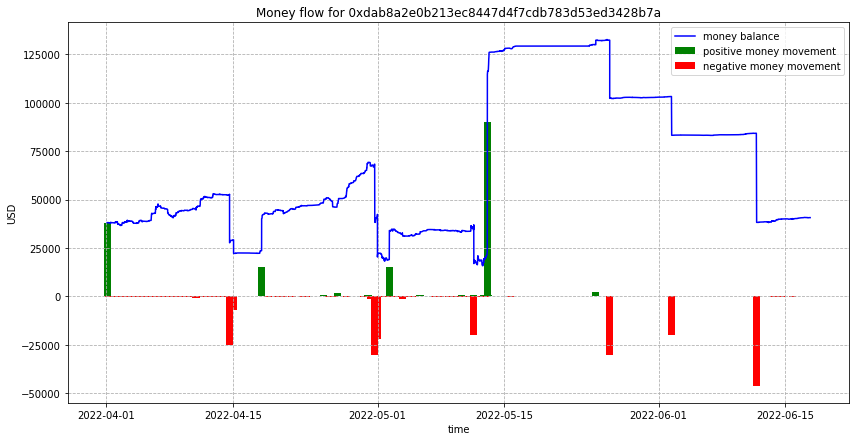

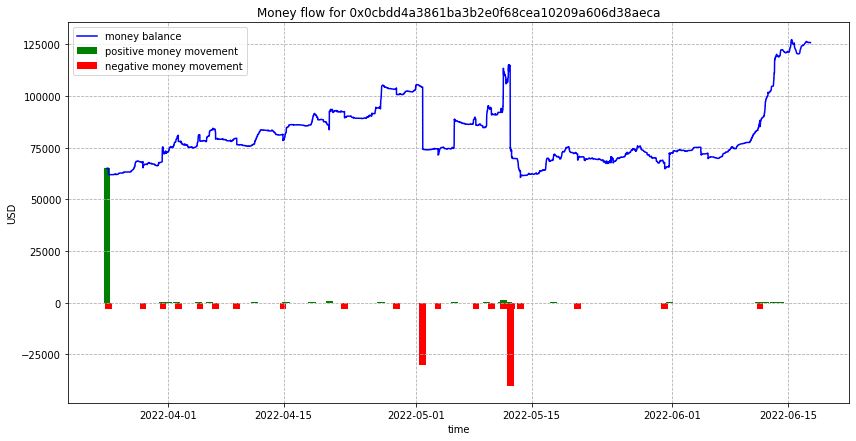

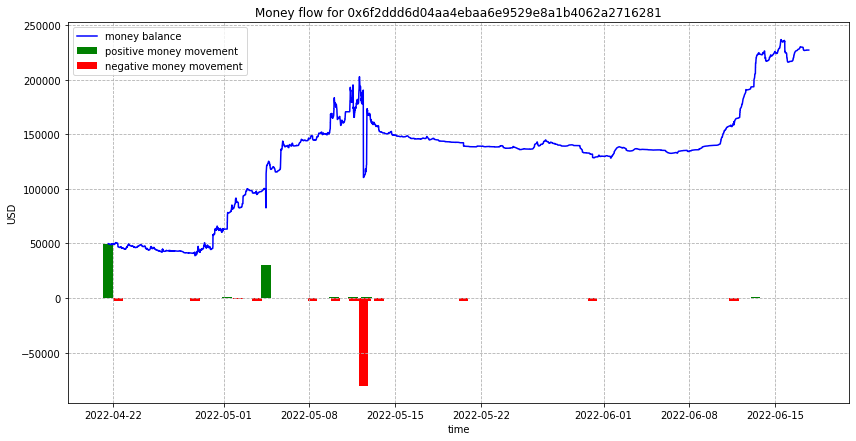

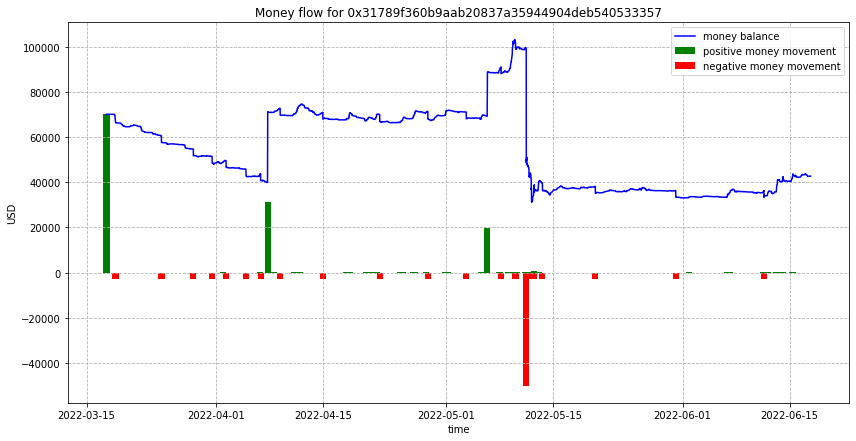

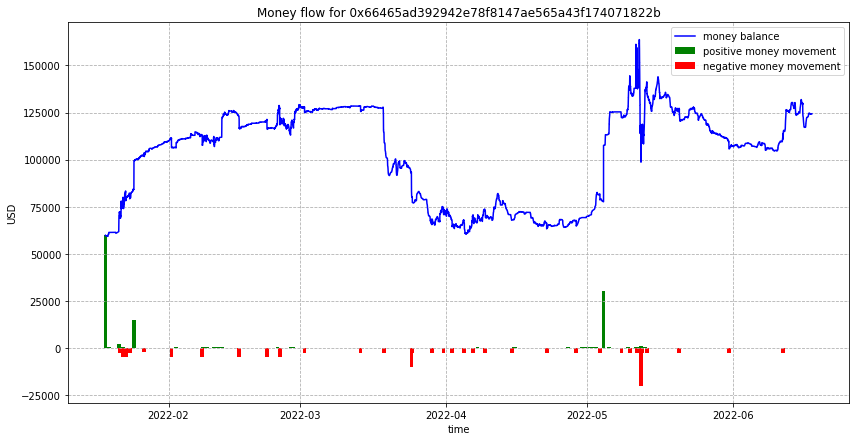

In [44]:
for trader in ["0xdab8a2e0b213ec8447d4f7cdb783d53ed3428b7a",
               "0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca",
               "0x6f2ddd6d04aa4ebaa6e9529e8a1b4062a2716281",
               "0x31789f360b9aab20837a35944904deb540533357",
               "0x66465ad392942e78f8147ae565a43f174071822b"]:
    trader_money_balance_df = get_trader_money_balance(master_trader_df, trader)
    show_trader_money_balance(trader_money_balance_df)

The charts presented below demonstrate all the parameters that can be referred to the trader with demonstration of the collected profits and losses (out of the realized PnL), collected funding payments, fees and liquidation fees. In most of the cases fees funding payments and liquidation fees will be equal to the 0 and therefore in most of the cases it will be "flatlined"

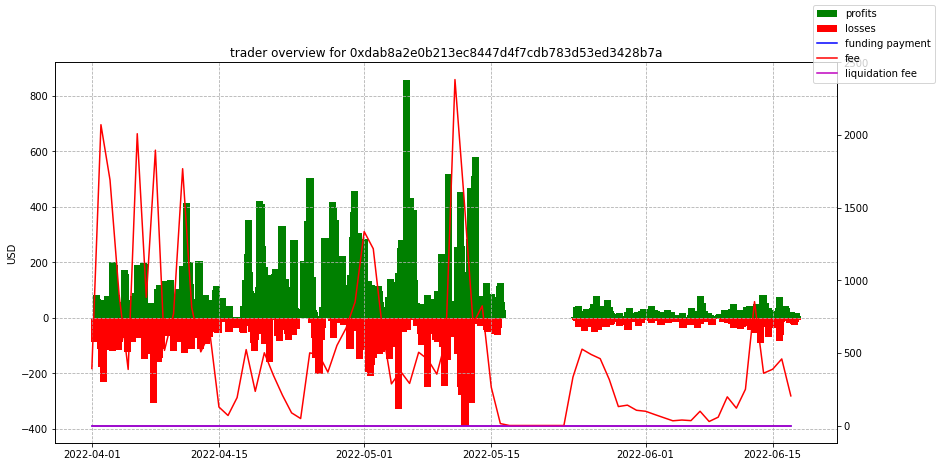

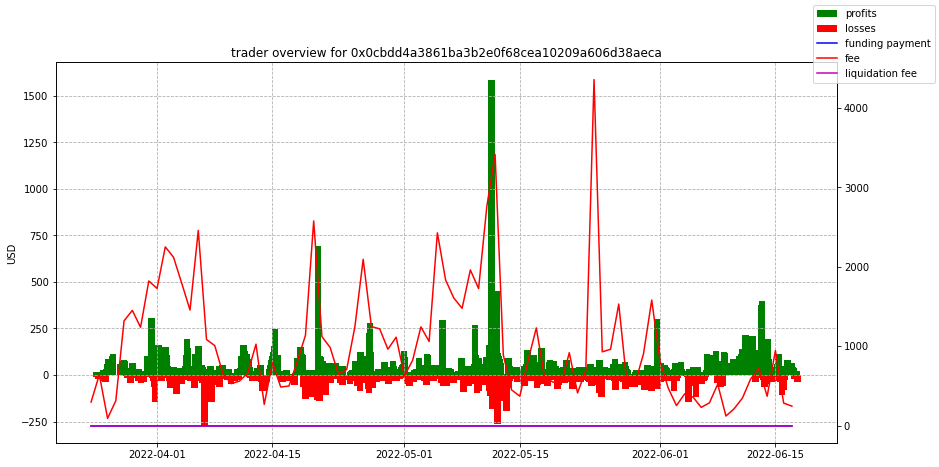

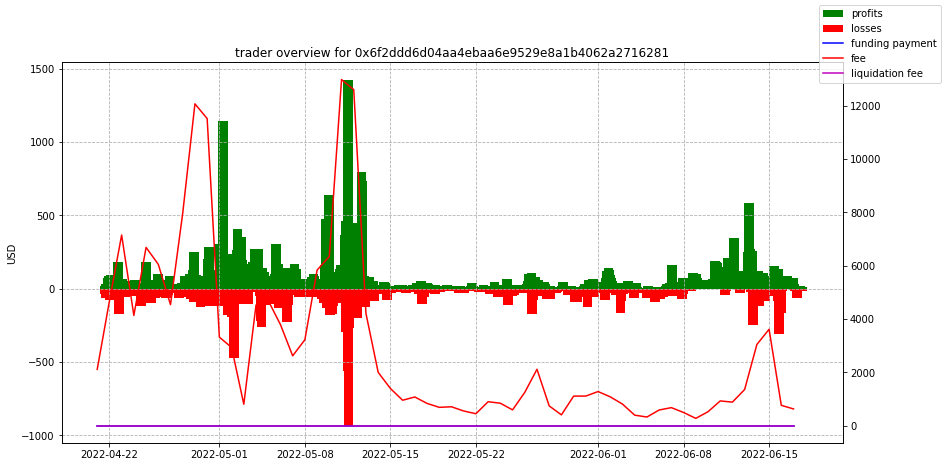

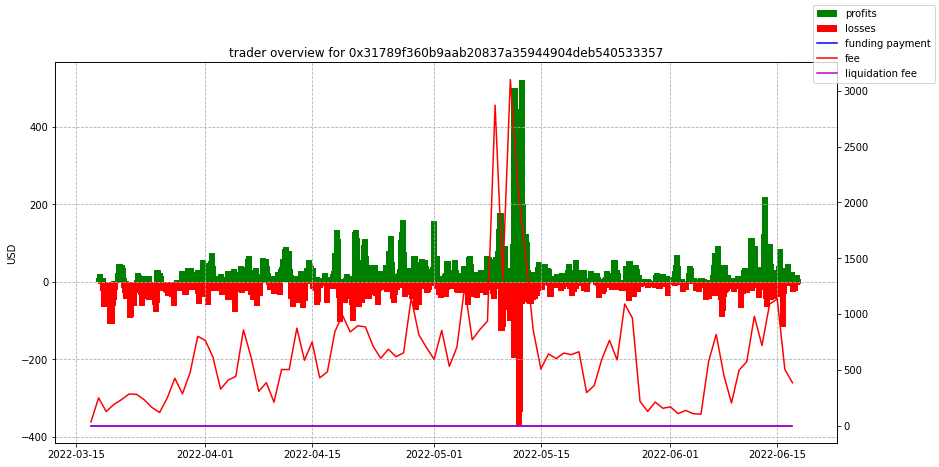

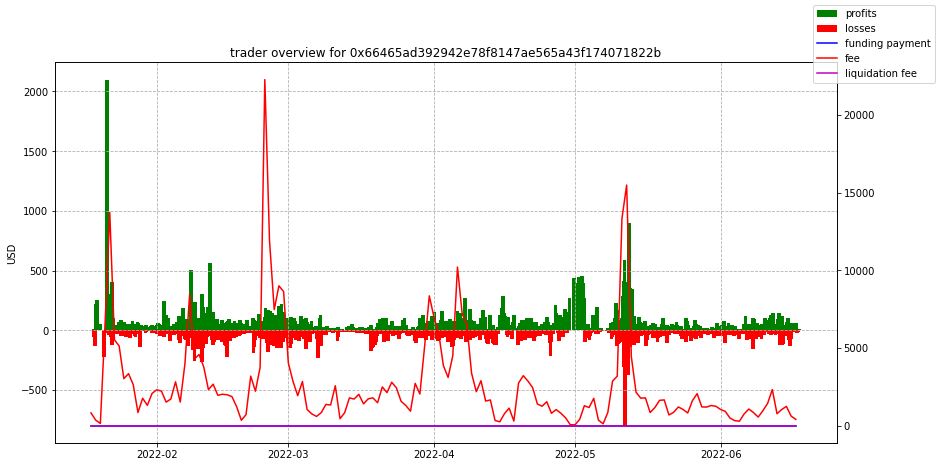

In [66]:
for trader in ["0xdab8a2e0b213ec8447d4f7cdb783d53ed3428b7a",
               "0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca",
               "0x6f2ddd6d04aa4ebaa6e9529e8a1b4062a2716281",
               "0x31789f360b9aab20837a35944904deb540533357",
               "0x66465ad392942e78f8147ae565a43f174071822b"]:
    show_trader_overview(master_trader_df, trader)

# Demonstration of the buying power

Considering that there is a calculation of the money that are "locked" for a specific trader it is possible to find "used" buying power. To understand how it works it is required to review principles by which leverage (buying power) is working.

Each trader is able to make its position bigger up to 10 times using a leverage, but considering that there is a concept of "common" margin for all currently opened positions there is no specification of the leverage used for the exact token or the exact position. Therefore, it was decided to go throught the another approach. Considering that there is a problem of "common" margin, application of the leverage will refer to the entire margin, not just the "dedicated" part and therefore application of the buying power will refer to all of the positions in the equal manner.

The best approach will be to get capitalization of the currently opened position (which is possible to do via ```open_notional```) per each pool where trader is participating and find what is the ratio in percents of the position capitalization respective to the margin (or current value of money balance). 

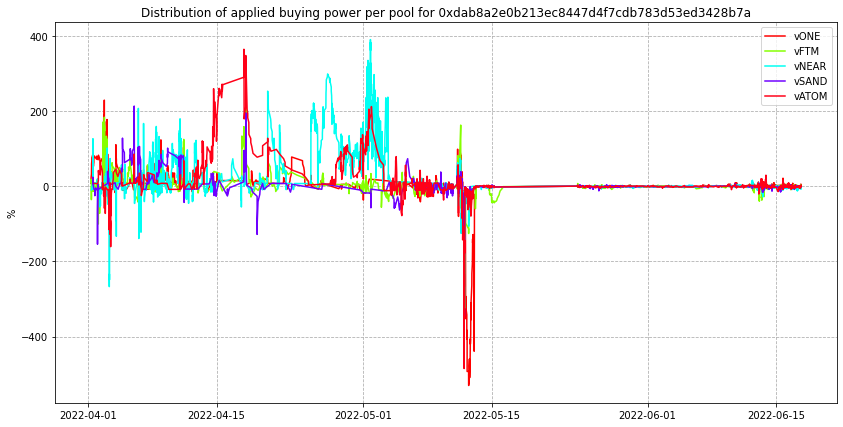

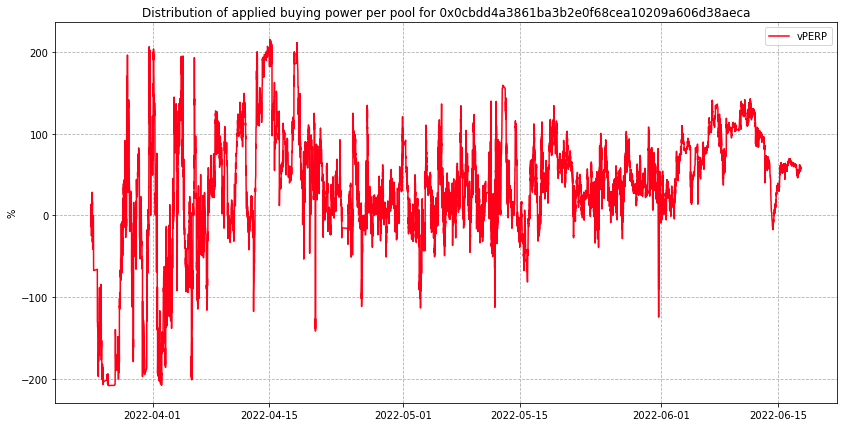

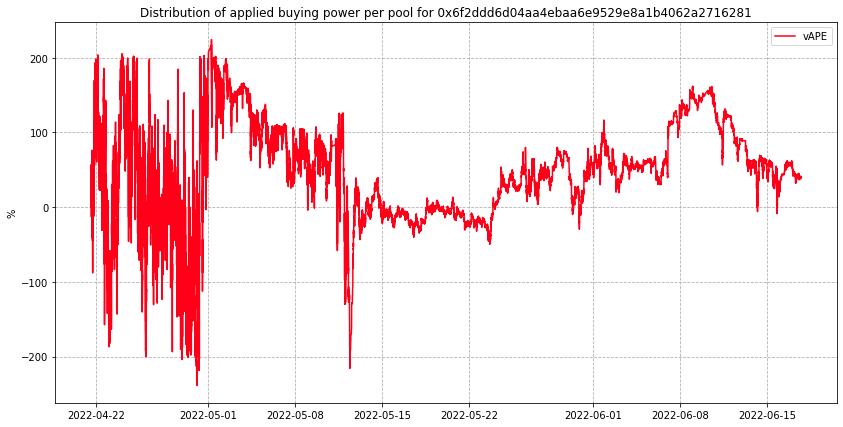

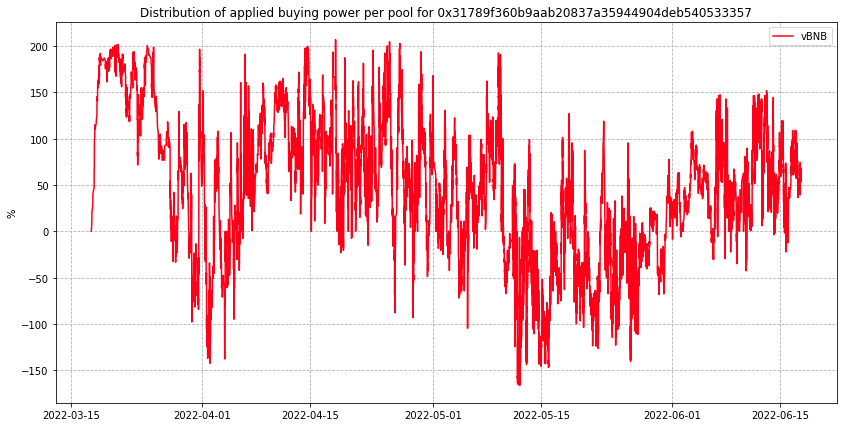

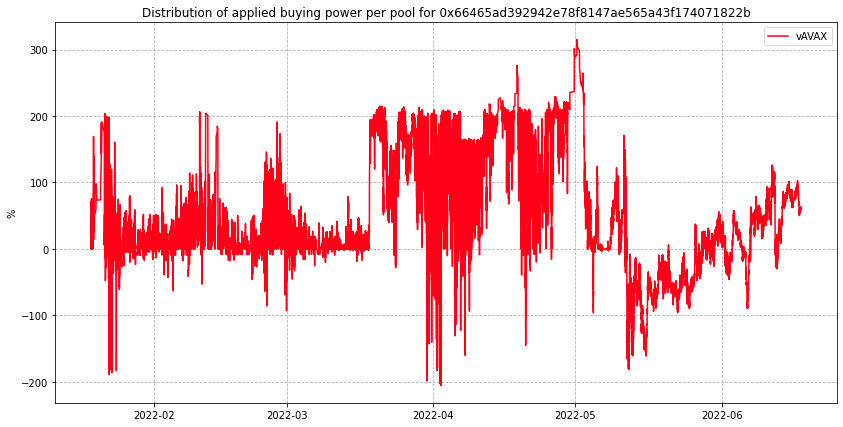

In [73]:
for trader in ["0xdab8a2e0b213ec8447d4f7cdb783d53ed3428b7a",
               "0x0cbdd4a3861ba3b2e0f68cea10209a606d38aeca",
               "0x6f2ddd6d04aa4ebaa6e9529e8a1b4062a2716281",
               "0x31789f360b9aab20837a35944904deb540533357",
               "0x66465ad392942e78f8147ae565a43f174071822b"]:
    trader_money_balance_df = get_trader_money_balance(master_trader_df, trader)
    show_buying_power(trader_money_balance_df)